In [681]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import warnings
import pymc as pm
import arviz as az
import bambi as bmb

# Plot settings
plt.style.use(
    "https://github.com/aeturrell/coding-for-economists/raw/main/plot_style.txt"
)
az.style.use("arviz-darkgrid")

# Pandas: Set max rows displayed for readability
pd.set_option("display.max_rows", 23)

# Set seed for random numbers
seed_for_prng = 78557
prng = np.random.default_rng(seed_for_prng)  # prng=probabilistic random number generator
# Turn off warnings
warnings.filterwarnings('ignore')
# check pymc version
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.2.2


In [471]:
import geopandas as gpd

In [513]:
df_transformed = pd.read_parquet("../data/scaled_features.parquet")

In [515]:
df = pd.read_parquet("../data/model_data.parquet")

In [473]:
#df = df[df.seg_difference>0]

In [591]:
form_diff = (
    "seg_difference ~ 1 + np.log(planar_measure) + np.log(street_length_total) + np.log(street_length_avg) +"
    "np.log(intersection_density_km) + self_loop_proportion +  np.log(circuity_avg) + node_props_dead_end  + node_props_4way + np.log(cyclomatic) + meshedness  +"
    "np.log(population) + np.log(pop_density) + np.log(ALAND) + np.log(AWATER) + I(meshedness*density)"
)

In [137]:
form_pct = (
    "pct_diff ~ 1 + planar_measure + np.log(street_length_total) + np.log(street_length_avg) +"
    "np.log(intersection_density_km) + self_loop_proportion +  circuity_avg + node_props_3way + node_props_4way + np.log(cyclomatic) + meshedness  +"
    "np.log(population) + np.log(pop_density) + np.log(ALAND) + np.log(AWATER)"
)

In [782]:
form_diff_pure = (
    "seg_difference ~ 1 + planar_measure + street_density_km +"
    "intersection_density_km + self_loop_proportion +  circuity_avg  + cyclomatic + meshedness +"
    "population + pop_density + ALAND + AWATER + I(circuity_avg*cyclomatic) + I(meshedness*cyclomatic) + I(circuity_avg*meshedness) "
)

I havent tested the speed yet, but if you use either `inference_method='nuts_blackjax'` or `inference_method='nuts_numpyro'` (both installable with mamba) then it runs *super* fast

In [783]:
model_diff = bmb.Model(form_diff_pure, df_transformed)
# Fit the model using 1000 on each of 4 chains
results = model_diff.fit(draws=2000, chains=6, inference_method='nuts_blackjax', cores=10)

Compiling...
Compilation time =  0:00:11.174851
Sampling...
Sampling time =  0:00:15.109350
Transforming variables...
Transformation time =  0:00:04.344908
Computing Log Likelihood...
Log Likelihood time =  0:00:00.328233


In [784]:
# Use ArviZ to plot the results
#az.plot_trace(results)

# Key summary and diagnostic info on the model parameters
az.summary(results, round_to=4)

mean       sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                      5.6299   5.9173 -5.4433  16.9956     0.0610   
planar_measure                 0.1498   0.1367 -0.1084   0.4013     0.0012   
street_density_km             -0.9008   0.3256 -1.5284  -0.3118     0.0033   
intersection_density_km        0.4898   0.5310 -0.5439   1.4598     0.0065   
self_loop_proportion          -0.1252   0.0678 -0.2514   0.0037     0.0006   
circuity_avg                  36.9013  20.4239 -0.9053  75.8063     0.2224   
cyclomatic                     0.7659   0.5055 -0.1664   1.7329     0.0061   
meshedness                     1.6346   0.5875  0.5242   2.7381     0.0064   
population                    -0.1359   1.5132 -3.0250   2.6827     0.0190   
pop_density                   -0.0261   1.5113 -2.8805   2.8089     0.0189   
ALAND                         -0.2119   1.5347 -3.0070   2.7665     0.0195   
AWATER                        -0.0804   0.0492 -0.1703   0.0138     0.0005   
I(circuity_avg * cyclomatic)  -3.6266   1.8612 -7.1301  -0.1252     0.0202   
I(meshedness * cyclomatic)    -0.1381   0.0515 -0.2331  -0.0406     0.0006   
I(circuity_avg * meshedness)  -1.8160   1.3847 -4.4371   0.7859     0.0133   
seg_difference_sigma           0.9677   0.0366  0.8997   1.0369     0.0003   

                              mcse_sd    ess_bulk   ess_tail   r_hat  
Intercept                      0.0451   9422.1929  9057.7483  1.0002  
planar_measure                 0.0010  12936.6820  8940.5317  1.0008  
street_density_km              0.0024   9612.5539  9122.9316  1.0009  
intersection_density_km        0.0048   6716.2107  6812.3572  1.0017  
self_loop_proportion           0.0004  13231.2309  9078.5975  0.9998  
circuity_avg                   0.1605   8435.6754  7717.8512  1.0004  
cyclomatic                     0.0043   6832.6941  6884.6712  1.0012  
meshedness                     0.0046   8413.6297  7348.6117  1.0002  
population                     0.0147   6386.2974  6504.4884  1.0004  
pop_density                    0.0150   6403.3381  6563.6877  1.0005  
ALAND                          0.0153   6253.5911  6813.9140  1.0006  
AWATER                         0.0004   9861.6182  9126.0770  1.0004  
I(circuity_avg * cyclomatic)   0.0146   8455.9373  7970.1656  1.0004  
I(meshedness * cyclomatic)     0.0004   8534.1386  7611.3370  1.0005  
I(circuity_avg * meshedness)   0.0105  10847.1231  8718.4181  1.0009  
seg_difference_sigma           0.0002  13248.0218  9121.8717  1.0003

array([<AxesSubplot:title={'left':'94.0% HDI'}>], dtype=object)

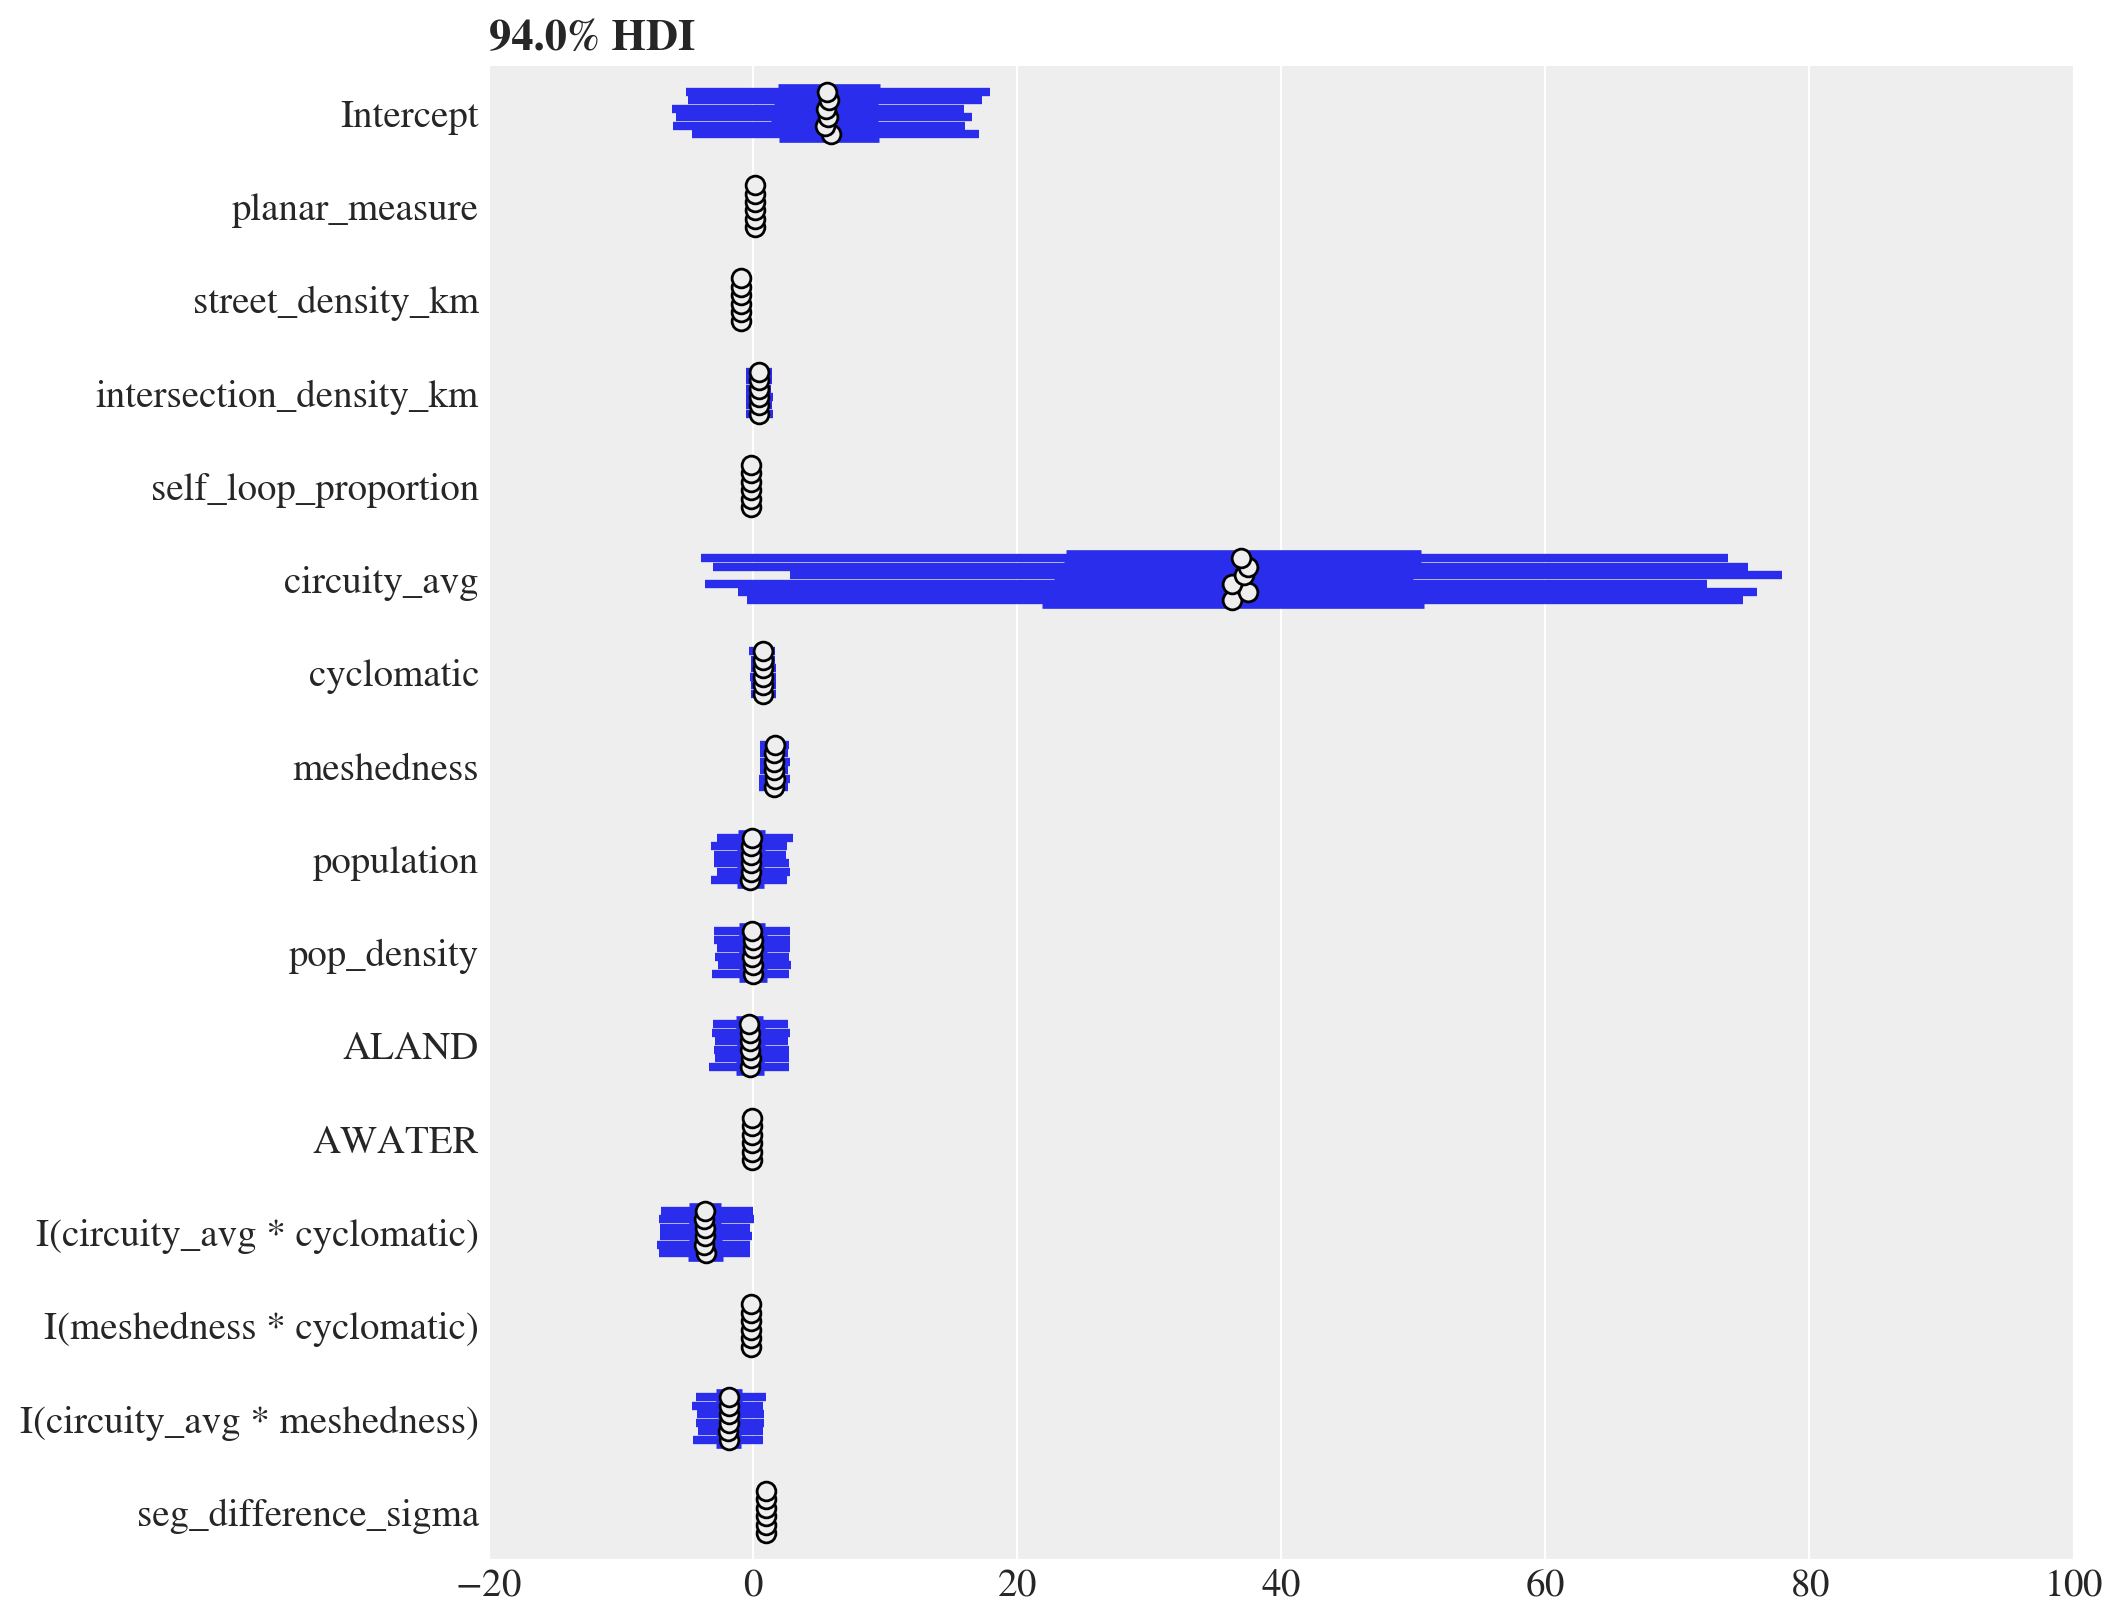

In [785]:
az.plot_forest(results,    figsize=(10.5, 8),
)

array([[<AxesSubplot:title={'left':'Intercept'}>,
        <AxesSubplot:title={'left':'planar_measure'}>,
        <AxesSubplot:title={'left':'street_density_km'}>],
       [<AxesSubplot:title={'left':'intersection_density_km'}>,
        <AxesSubplot:title={'left':'self_loop_proportion'}>,
        <AxesSubplot:title={'left':'circuity_avg'}>],
       [<AxesSubplot:title={'left':'cyclomatic'}>,
        <AxesSubplot:title={'left':'meshedness'}>,
        <AxesSubplot:title={'left':'population'}>],
       [<AxesSubplot:title={'left':'pop_density'}>,
        <AxesSubplot:title={'left':'ALAND'}>,
        <AxesSubplot:title={'left':'AWATER'}>],
       [<AxesSubplot:title={'left':'I(circuity_avg * cyclomatic)'}>,
        <AxesSubplot:title={'left':'I(meshedness * cyclomatic)'}>,
        <AxesSubplot:title={'left':'seg_difference_sigma'}>]],
      dtype=object)

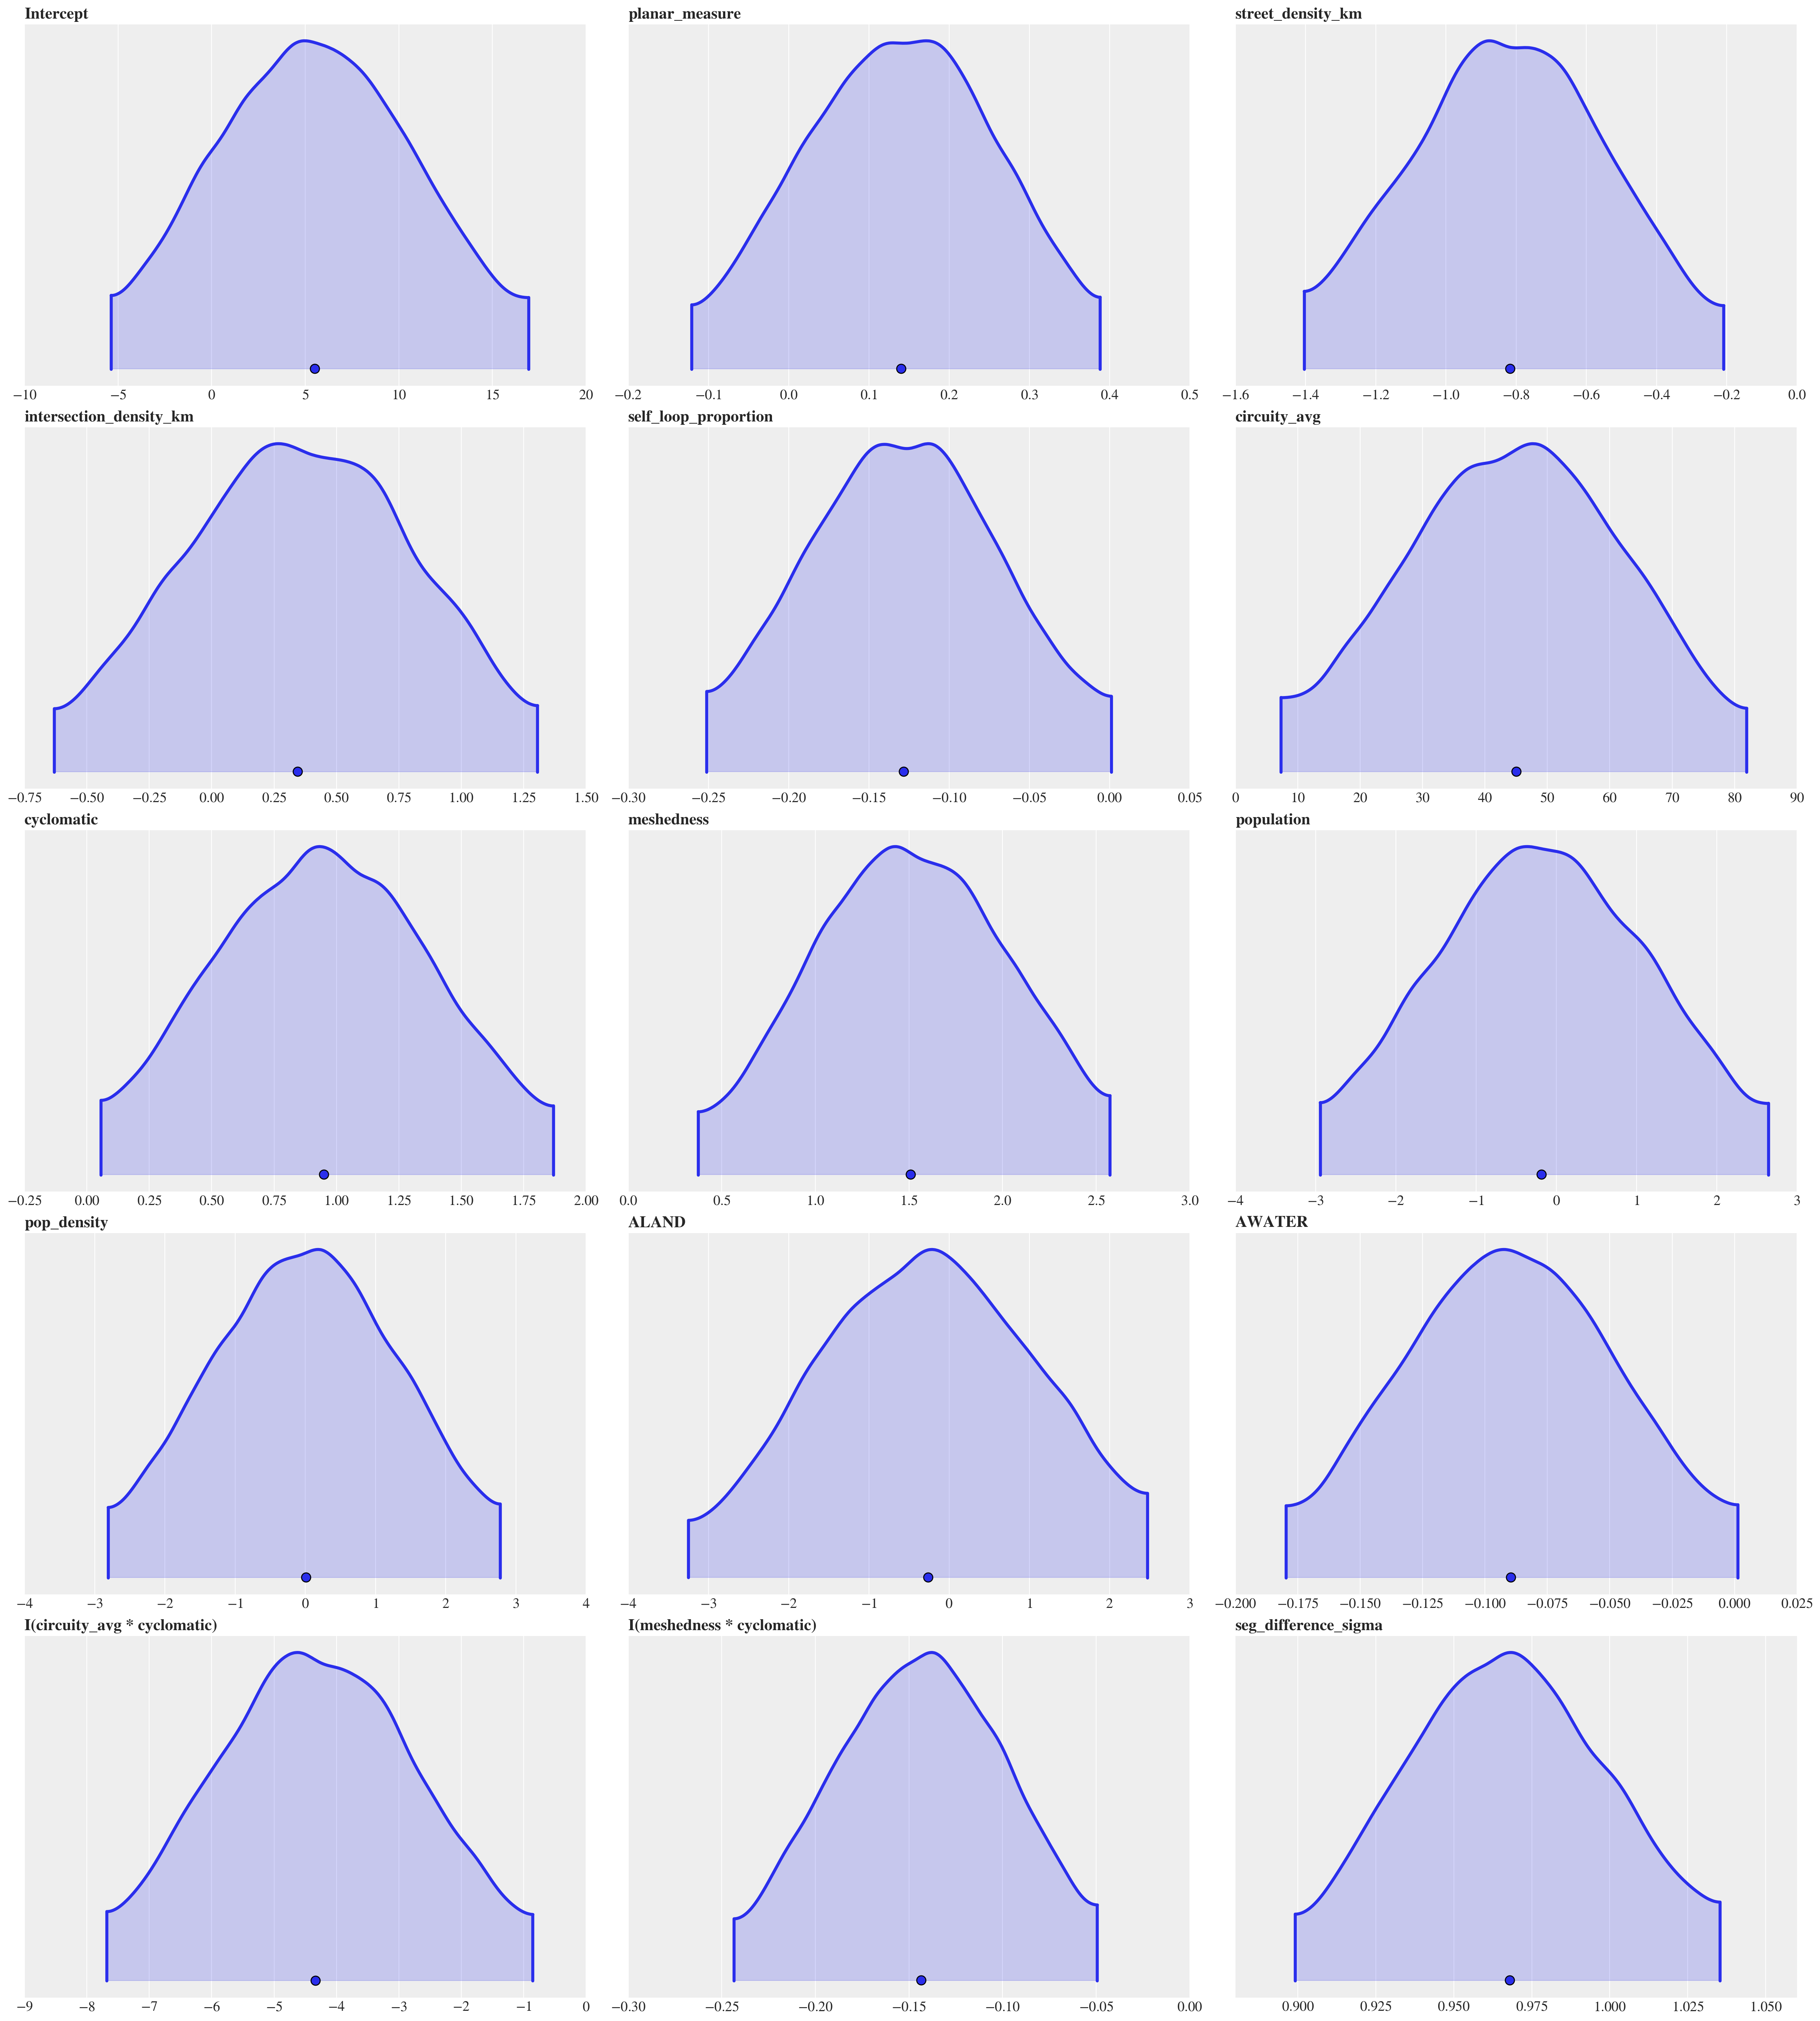

In [778]:
#az.style.use("arviz-doc")

az.plot_density(results, shade=0.2)

# $\Delta_{pct}$

In [689]:
form_pct_pure = (
    "pct_diff ~ 1 + planar_measure + street_length_total + street_length_avg + street_density_km +"
    "intersection_density_km + self_loop_proportion +  circuity_avg + cyclomatic + meshedness  +"
    "population + pop_density + ALAND + AWATER + I(circuity_avg*cyclomatic) + I(meshedness*cyclomatic) "
)

In [701]:
form_pct_pure_interaction = (
    "pct_diff ~ 1 + planar_measure + street_length_total + street_length_avg + street_density_km +"
    "intersection_density_km + self_loop_proportion +  circuity_avg  + node_props_3way  + node_props_4way + node_props_dead_end + cyclomatic + meshedness +"
    "population + pop_density + ALAND + AWATER + I(circuity_avg*cyclomatic)  + I(cyclomatic*street_length_total) + I(meshedness*cyclomatic) + I(node_props_dead_end*cyclomatic)"
)

In [702]:
model_pct = bmb.Model(form_pct_pure, df_transformed)
results_pct = model_pct.fit(draws=2000, chains=6, inference_method='nuts_numpyro', cores=10)

Compiling...
Compilation time =  0:00:04.868634
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:17.010175
Transforming variables...
Transformation time =  0:00:00.005394
Computing Log Likelihood...
Log Likelihood time =  0:00:00.283169


In [703]:
model_pct_interaction = bmb.Model(form_pct_pure_interaction, df_transformed)
results_pct_interaction = model_pct_interaction.fit(draws=2000, chains=6, inference_method='nuts_numpyro', cores=10)

Compiling...
Compilation time =  0:00:08.403347
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:21.494553
Transforming variables...
Transformation time =  0:00:00.006530
Computing Log Likelihood...
Log Likelihood time =  0:00:00.410472


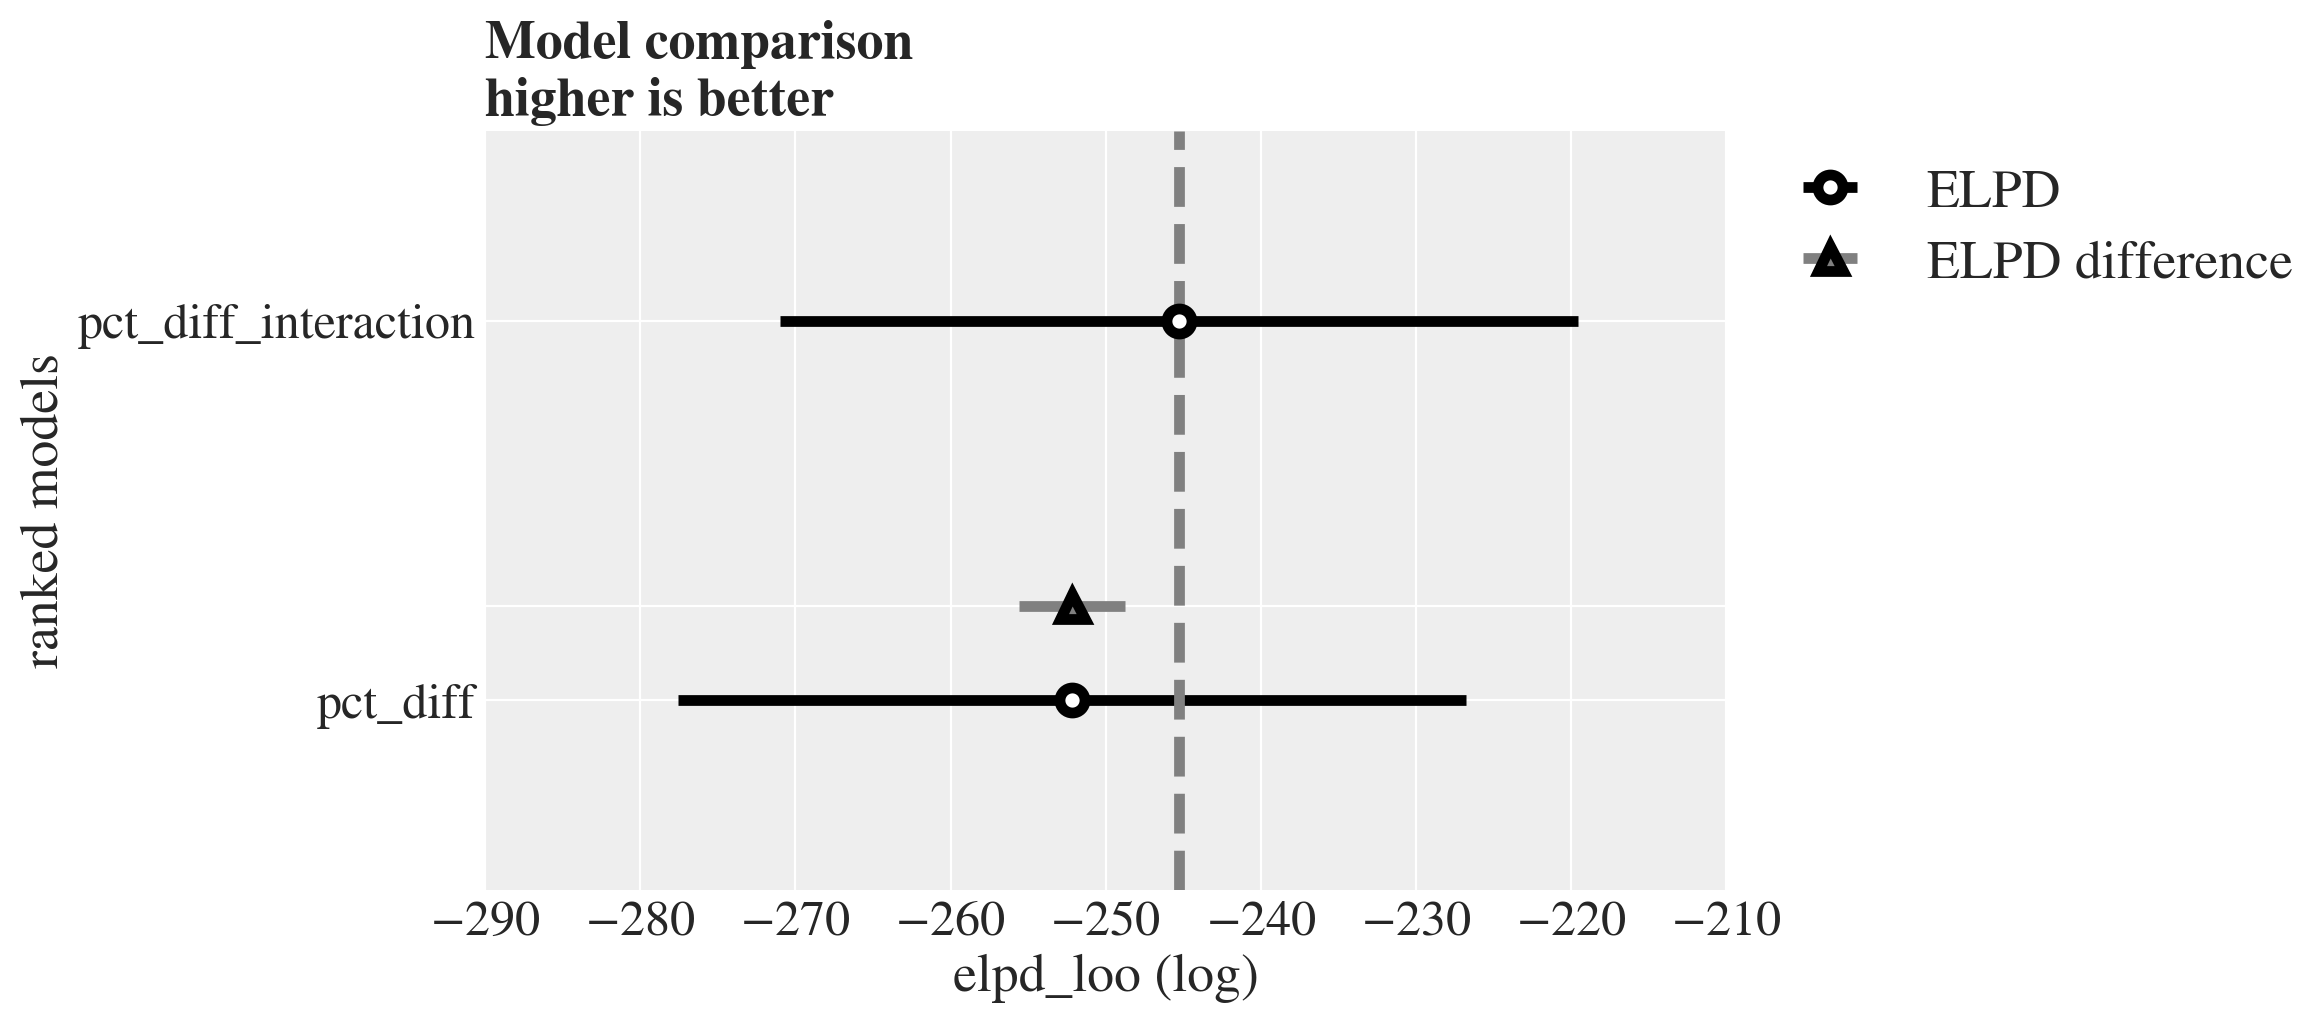

In [704]:
model_compare = az.compare(
    {
        "pct_diff": results_pct,
        "pct_diff_interaction": results_pct_interaction,
    }
)
az.plot_compare(model_compare, figsize=(11.5, 5))

plt.show()

The model with the interaction fits better

In [705]:
az.summary(results_pct_interaction, round_to=4)

mean       sd   hdi_3%  hdi_97%  \
Intercept                            -2.0350   5.4877 -12.3446   8.0423   
planar_measure                       -1.0115   0.0649  -1.1352  -0.8928   
street_length_total                   0.7437   1.2724  -1.5793   3.2548   
street_length_avg                    -0.5780   1.8632  -4.0914   2.9165   
street_density_km                    -0.3038   1.5639  -3.1818   2.7130   
intersection_density_km               0.0688   1.5577  -2.8299   3.0448   
self_loop_proportion                 -0.0059   0.0348  -0.0751   0.0568   
circuity_avg                         26.2607  10.1306   6.9685  44.8708   
node_props_3way                      -0.9182   0.3004  -1.4709  -0.3346   
node_props_4way                       0.3324   0.2748  -0.1845   0.8522   
node_props_dead_end                  -1.5838   0.9893  -3.4117   0.2967   
cyclomatic                            0.2649   1.2420  -2.0383   2.6488   
meshedness                           -1.0273   1.0098  -3.0021   0.8086   
population                            0.0581   1.0163  -1.9287   1.8820   
pop_density                           0.1007   1.0153  -1.8181   1.9927   
ALAND                                -0.0194   1.0288  -1.8553   1.9814   
AWATER                               -0.0498   0.0235  -0.0921  -0.0046   
I(circuity_avg * cyclomatic)         -2.4092   0.9273  -4.0897  -0.6224   
I(cyclomatic * street_length_total)  -0.0246   0.0234  -0.0685   0.0194   
I(meshedness * cyclomatic)           -0.2158   0.0685  -0.3445  -0.0866   
I(node_props_dead_end * cyclomatic)  -0.1500   0.0696  -0.2831  -0.0201   
pct_diff_sigma                        0.4593   0.0177   0.4258   0.4921   

                                     mcse_mean  mcse_sd    ess_bulk  \
Intercept                               0.0400   0.0471  18939.5748   
planar_measure                          0.0004   0.0003  22020.1469   
street_length_total                     0.0121   0.0108  11137.8840   
street_length_avg                       0.0197   0.0168   8908.9820   
street_density_km                       0.0156   0.0147   9988.4149   
intersection_density_km                 0.0156   0.0148  10022.1129   
self_loop_proportion                    0.0002   0.0004  22300.5246   
circuity_avg                            0.0925   0.0679  11989.5637   
node_props_3way                         0.0030   0.0022   9978.7116   
node_props_4way                         0.0019   0.0018  21052.6372   
node_props_dead_end                     0.0103   0.0074   9254.1351   
cyclomatic                              0.0118   0.0116  11012.3440   
meshedness                              0.0105   0.0078   9225.8668   
population                              0.0108   0.0090   8902.2256   
pop_density                             0.0108   0.0090   8830.7861   
ALAND                                   0.0110   0.0091   8836.5342   
AWATER                                  0.0002   0.0001  21692.4486   
I(circuity_avg * cyclomatic)            0.0085   0.0062  11957.1757   
I(cyclomatic * street_length_total)     0.0002   0.0002  21181.0057   
I(meshedness * cyclomatic)              0.0007   0.0005  10128.9040   
I(node_props_dead_end * cyclomatic)     0.0007   0.0005   9783.6810   
pct_diff_sigma                          0.0001   0.0001  21433.5386   

                                      ess_tail   r_hat  
Intercept                            9694.0910  1.0005  
planar_measure                       8809.8336  1.0004  
street_length_total                  8793.4054  1.0002  
street_length_avg                    8146.5512  1.0008  
street_density_km                    7967.6075  1.0012  
intersection_density_km              7805.1626  1.0012  
self_loop_proportion                 8270.9638  1.0002  
circuity_avg                         8607.1155  1.0008  
node_props_3way                      8848.5288  1.0003  
node_props_4way                      8896.4645  1.0006  
node_props_dead_end                  8281.8456  1.000

array([<AxesSubplot:title={'left':'94.0% HDI'}>], dtype=object)

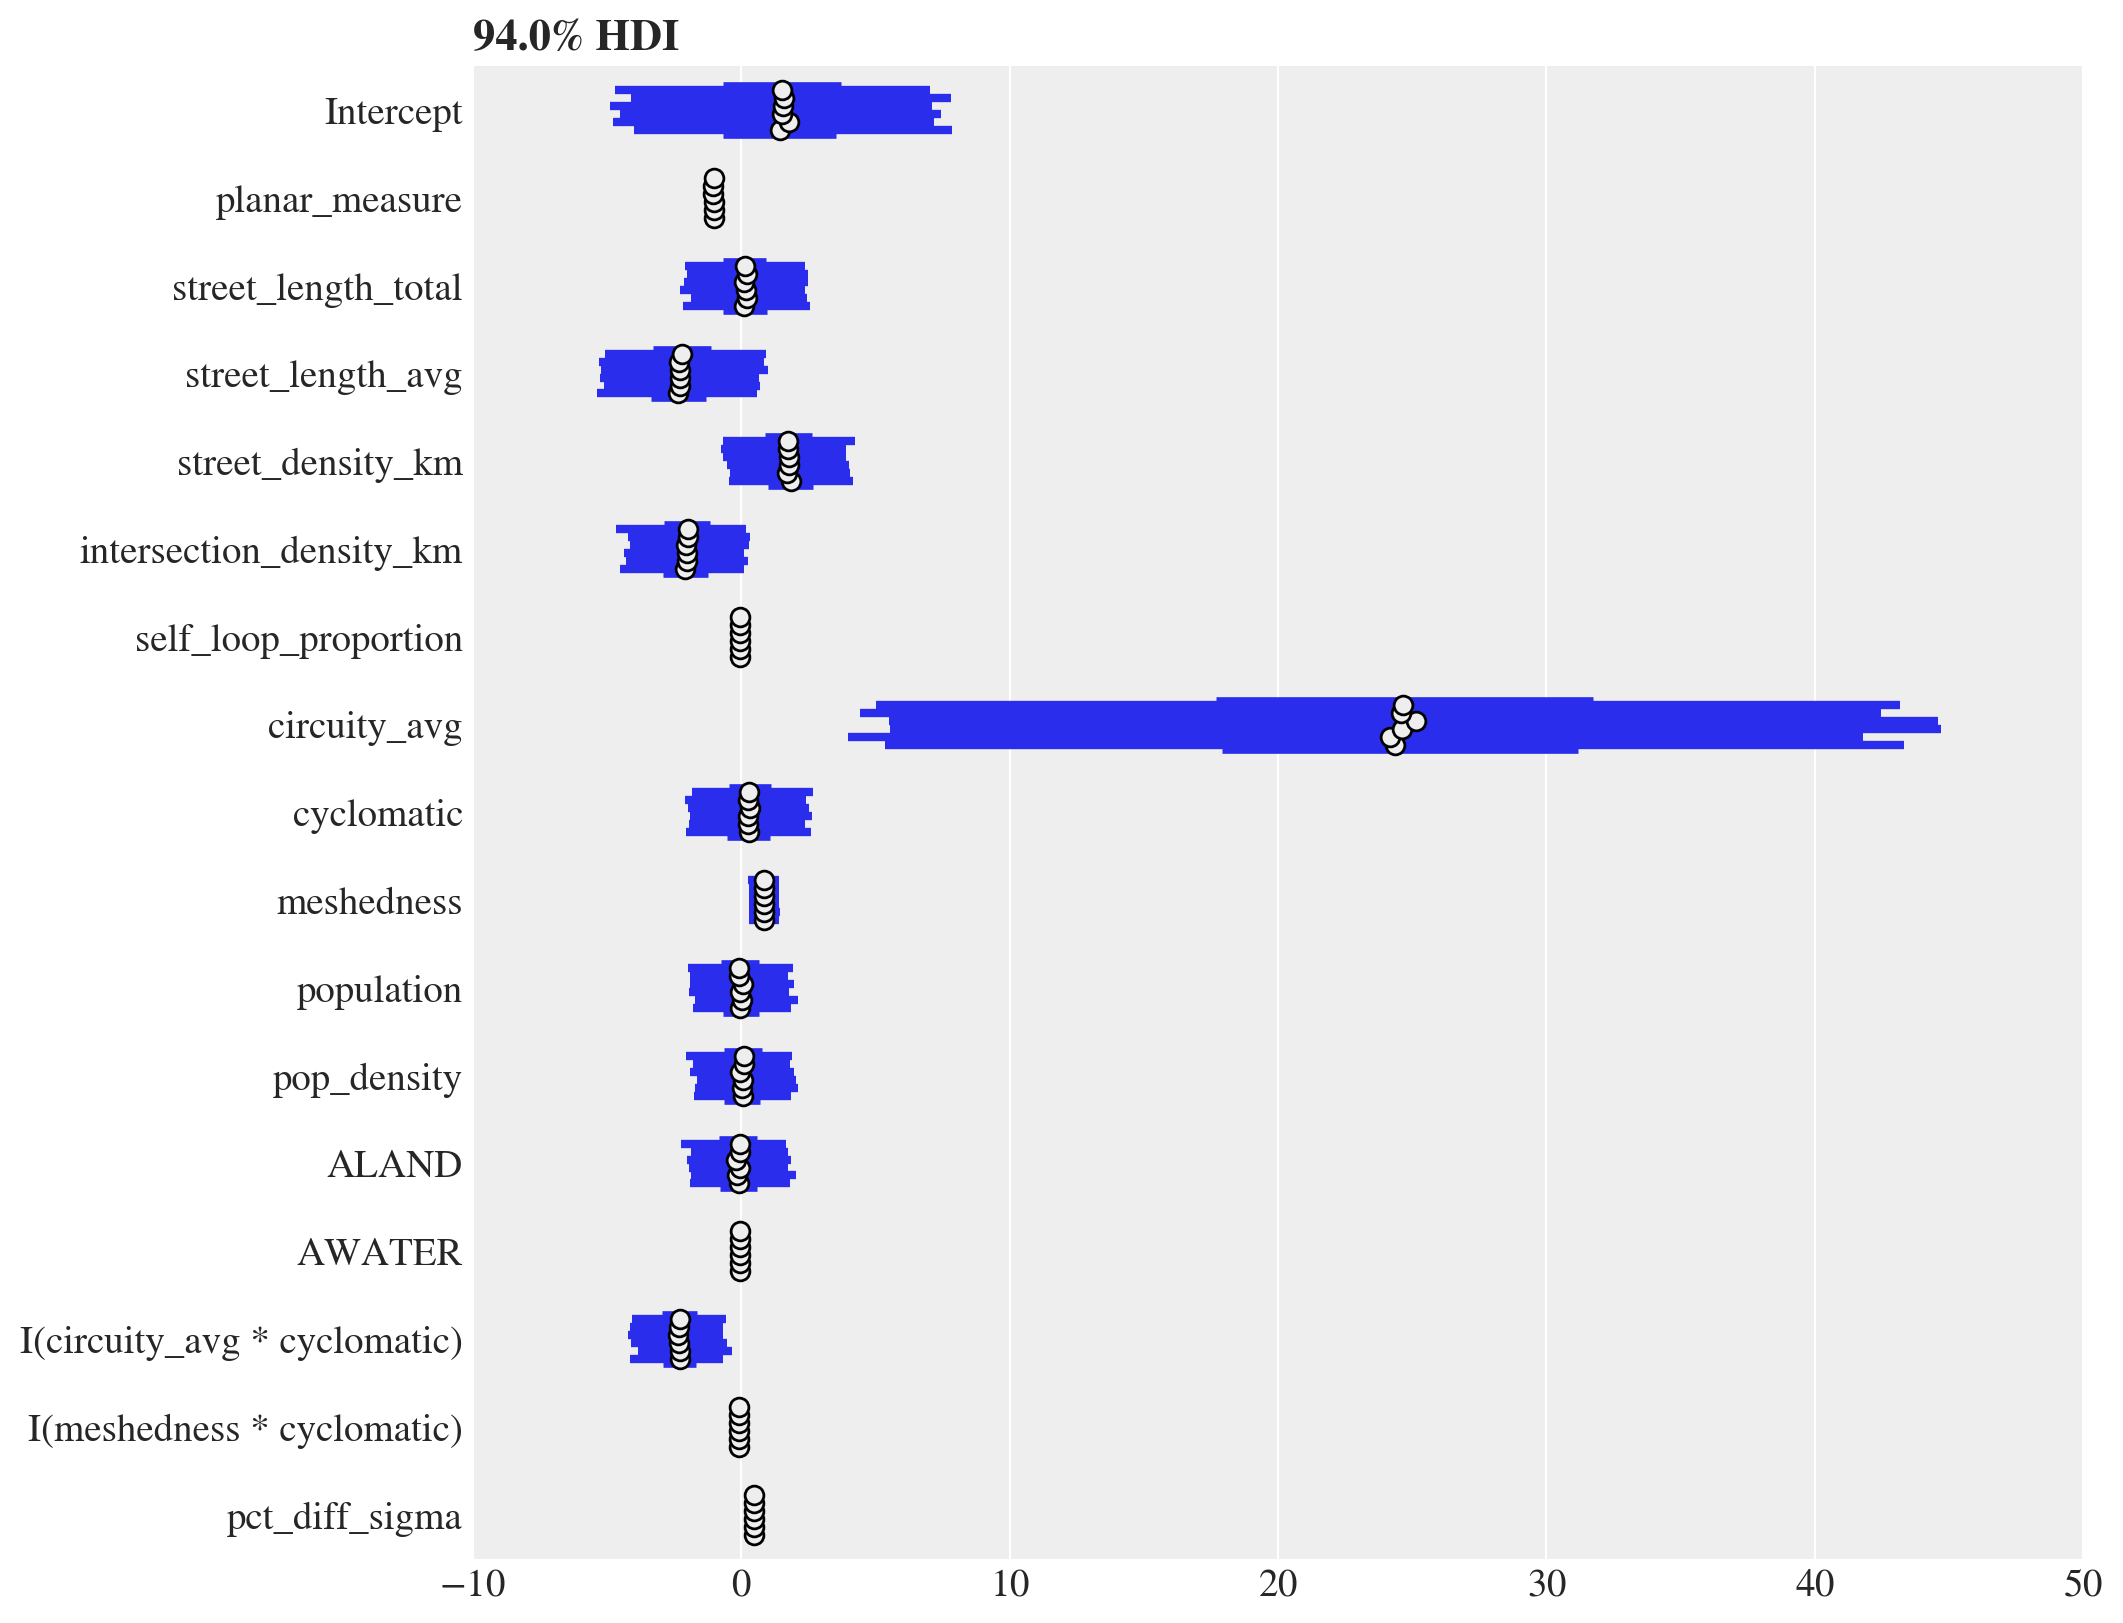

In [699]:
az.plot_forest(results_pct,    figsize=(10.5, 8),
)

array([<AxesSubplot:title={'left':'94.0% HDI'}>], dtype=object)

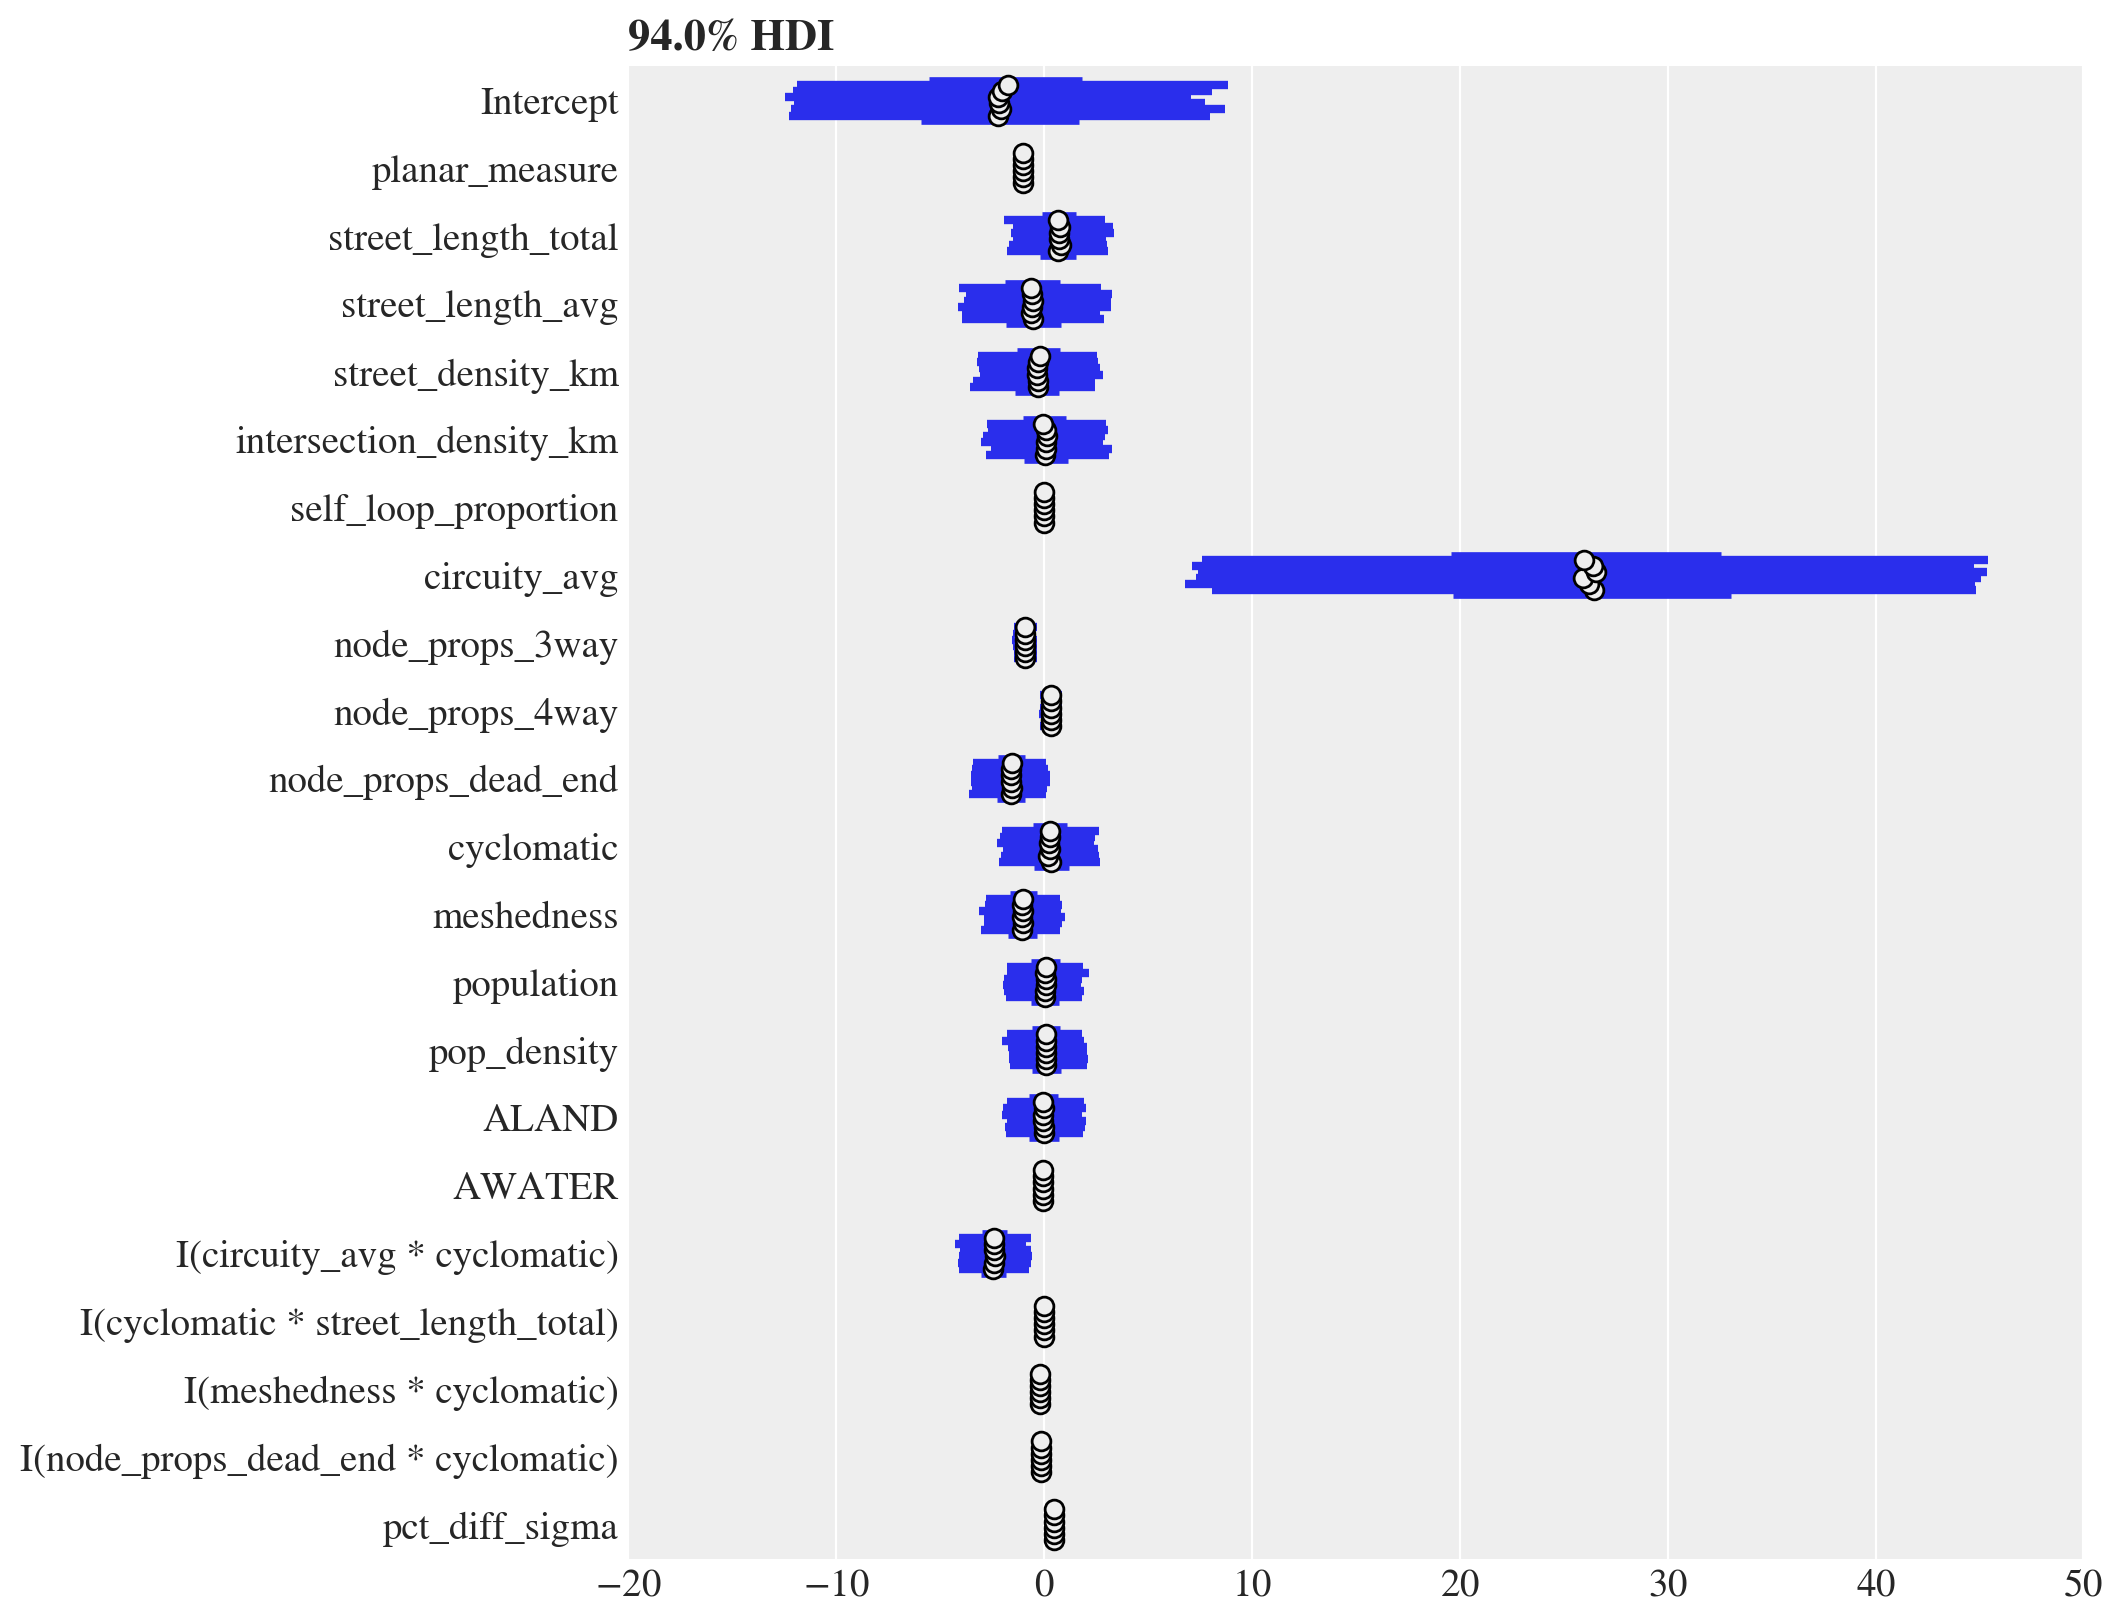

In [706]:
az.plot_forest(results_pct_interaction,    figsize=(10.5, 8),
)

array([[<AxesSubplot:title={'left':'Intercept'}>,
        <AxesSubplot:title={'left':'Intercept'}>],
       [<AxesSubplot:title={'left':'planar_measure'}>,
        <AxesSubplot:title={'left':'planar_measure'}>],
       [<AxesSubplot:title={'left':'street_length_total'}>,
        <AxesSubplot:title={'left':'street_length_total'}>],
       [<AxesSubplot:title={'left':'street_length_avg'}>,
        <AxesSubplot:title={'left':'street_length_avg'}>],
       [<AxesSubplot:title={'left':'street_density_km'}>,
        <AxesSubplot:title={'left':'street_density_km'}>],
       [<AxesSubplot:title={'left':'intersection_density_km'}>,
        <AxesSubplot:title={'left':'intersection_density_km'}>],
       [<AxesSubplot:title={'left':'self_loop_proportion'}>,
        <AxesSubplot:title={'left':'self_loop_proportion'}>],
       [<AxesSubplot:title={'left':'circuity_avg'}>,
        <AxesSubplot:title={'left':'circuity_avg'}>],
       [<AxesSubplot:title={'left':'node_props_3way'}>,
        <AxesSubpl

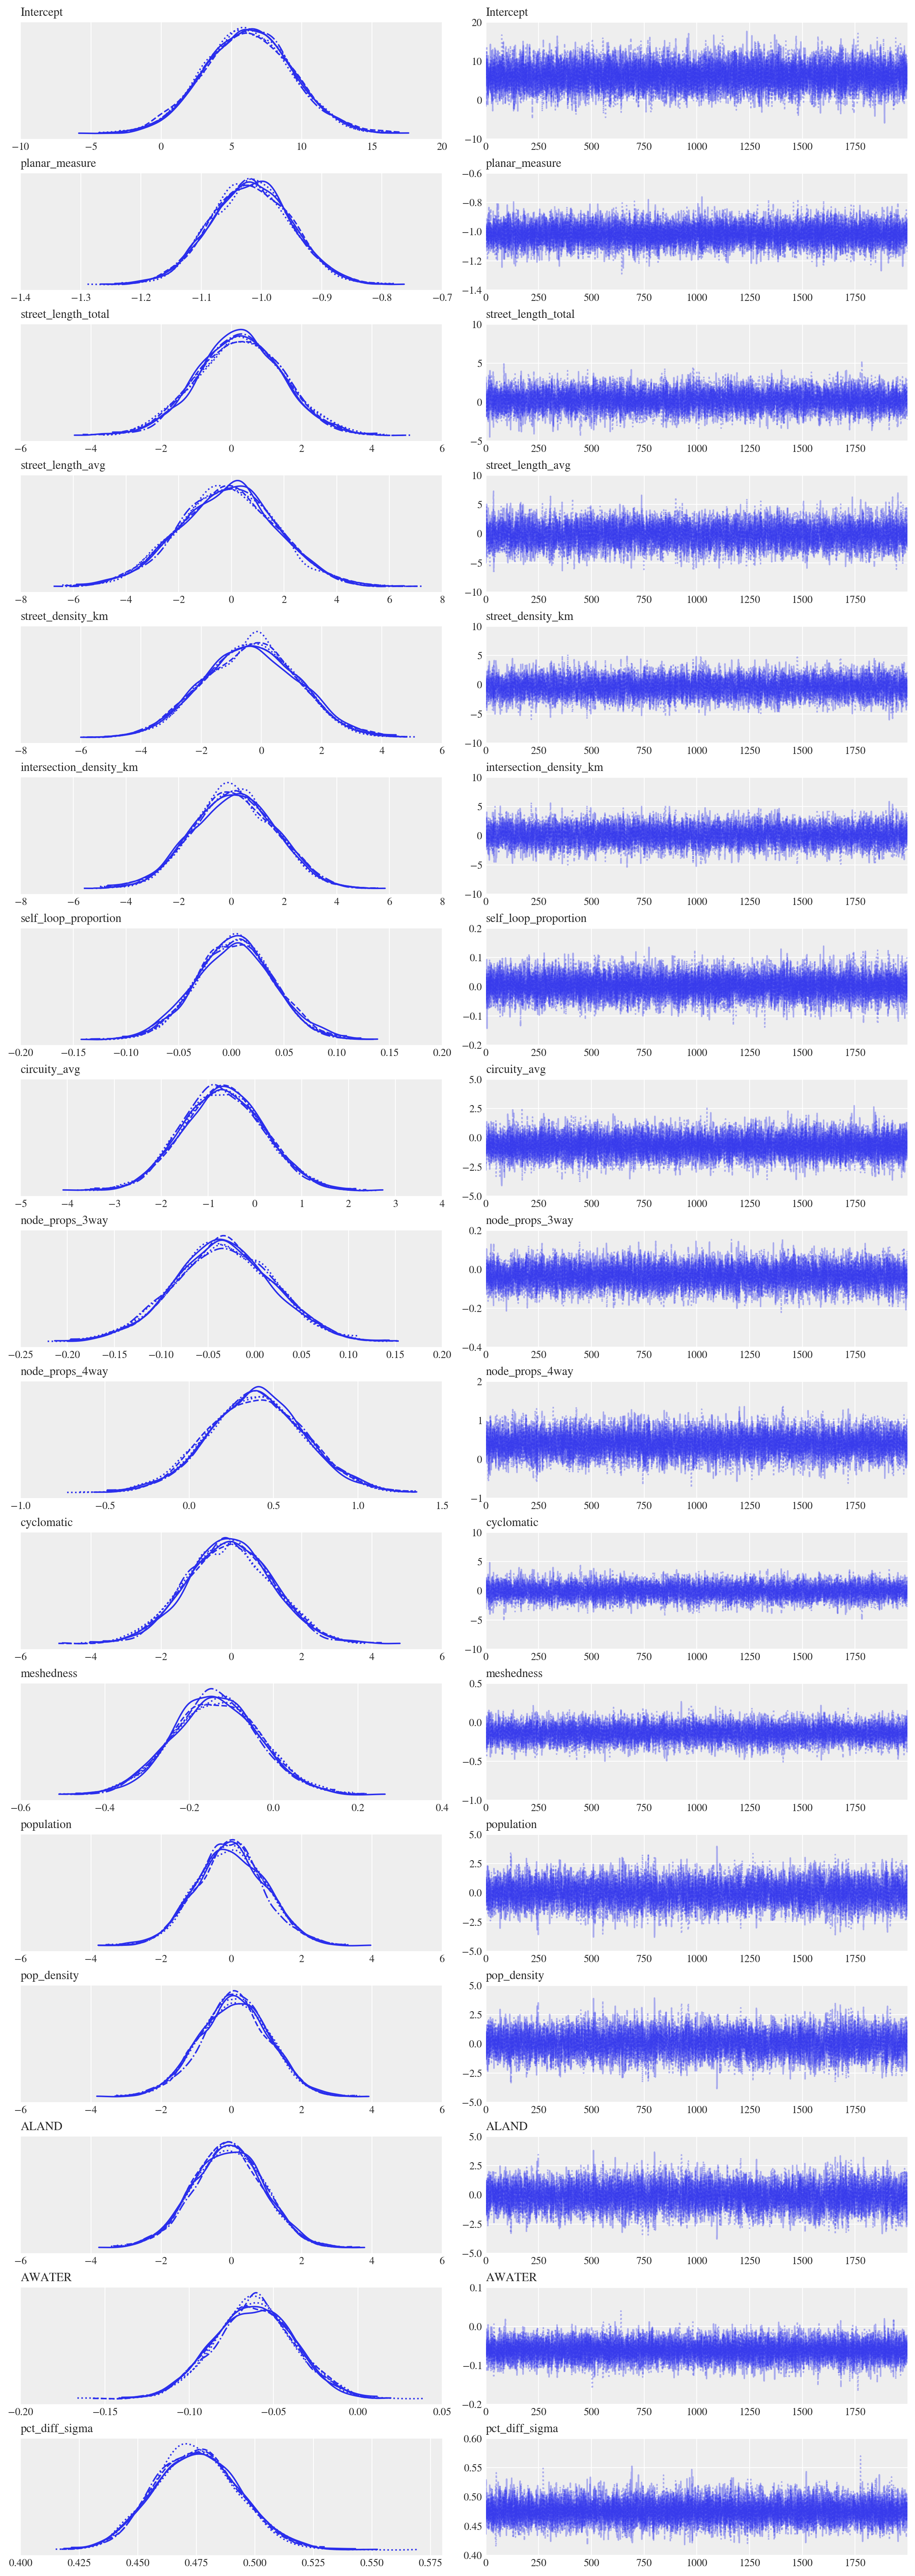

In [531]:
az.plot_trace(results_pct)

In [337]:
df.pct_change

Index(['planar_measure', 'network_measure', 'streets_per_node_avg',
       'street_length_total', 'street_segment_count', 'street_length_avg',
       'street_density_km', 'circuity_avg', 'intersection_count',
       'intersection_density_km', 'self_loop_proportion', 'node_props_4way',
       'cyclomatic', 'ALAND', 'AWATER', 'population', 'pop_density',
       'seg_difference', 'node_props_dead_end', 'node_props_3way',
       'meshedness', 'k_avg', 'gamma'],
      dtype='object')

<AxesSubplot:>

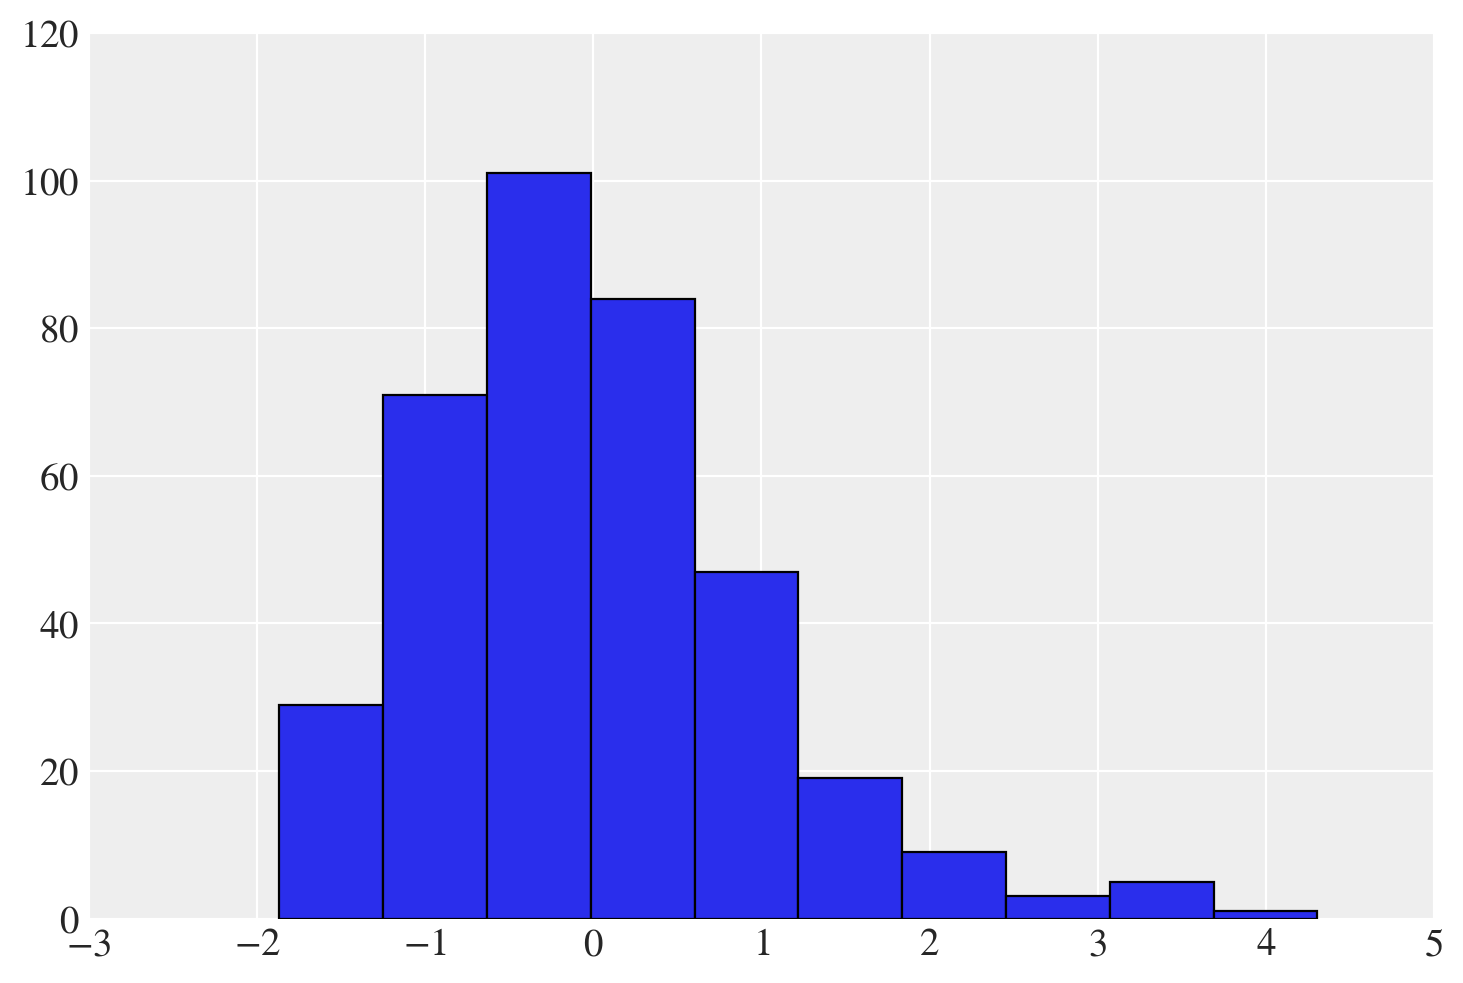

In [532]:
df_transformed.self_loop_proportion.hist()